#Parcial #4, Metodos Computacionales#
****
**Realizado por:** Juan Sebastian Pabon Martinez

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as spo

In [82]:

data=pd.read_csv('Data.txt')
data=data[data.angle == 30.0]

In [84]:
def coriolis(h,lamda,p,g=9.81):
  one=(np.sqrt(2)*2)/3
  two=p*np.cos(lamda)
  three= np.sqrt(h**3/g)
  y=one*two*three
  return 2*np.sqrt(2)*(1/3)*p*np.cos(np.deg2rad(lamda))*np.sqrt(h**3/g)

In [85]:
def Chi2(p,h,y,sigmay,angle=30,g=9.81):
    return np.sum ( (y-coriolis(h,angle,p))**2/(2*sigmay**2) )


In [86]:
h=data.h
y= data.y
sigma= data.sigmay

In [87]:
p=np.ones(1)
nll = lambda *p: Chi2(*p)

resultado = spo.minimize( nll, p, args=(h,y,sigma),options={'disp':True} )

Optimization terminated successfully.
         Current function value: 1.145718
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4


In [88]:
omega= resultado.x
print("El valor mejor aproximado para omega es: {}".format(omega))

El valor mejor aproximado para omega es: [7.24399804e-05]


Text(0, 0.5, 'y')

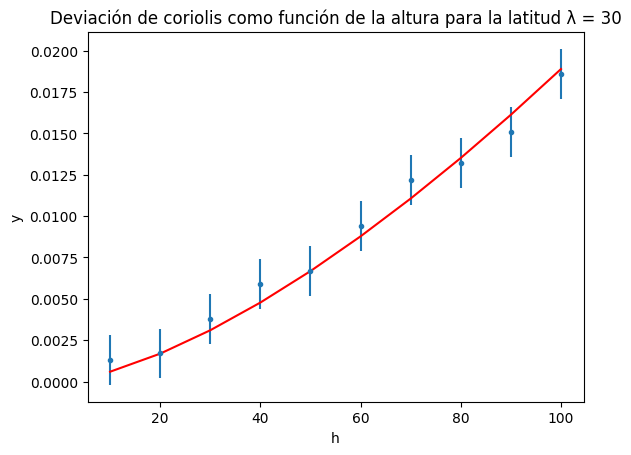

In [89]:
modelo= coriolis(h,30,omega)
plt.errorbar(h,y,sigma,fmt='.')
plt.plot(h,modelo,color='r')
plt.title('Deviación de coriolis como función de la altura para la latitud λ = 30')
plt.xlabel('h')
plt.ylabel('y')

#**Propagación de la incertidumbre de la aceleración de la gravedad:**

In [98]:
data=pd.read_csv('Data.txt')

In [99]:
h=data.h
y= data.y
sigma= data.sigmay

In [103]:
Gravity= []
Omega=[]
for i in range(300):
  Gravedad = 9.81 + np.random.normal(loc=0,scale=1)
  Gravity.append(Gravedad)
  y = y + np.random.normal( loc=0, scale=sigma[0], size=len(y) )
  resultado = spo.minimize( nll, p, args=(h,y,sigma),options={'disp':True} )
  Omega.append(resultado.x)


Gravity=np.array(Gravity)
Omega= np.array(Omega)

Optimization terminated successfully.
         Current function value: 12031.165526
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 12046.764231
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 12174.862482
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 12126.787312
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 11961.731247
         Iterations: 4
         Function evaluations: 36
         Gradient evaluations: 18
         Current function value: 12268.245830
         Iterations: 3
         Function evaluations: 75
         Gradient evaluations

300